In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
from time import process_time
from scipy import stats
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, precision_recall_curve, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
pd.options.mode.chained_assignment = None # For warnings

### Getting the data

##### Columns names and descriptions

In [5]:
# Read the csv with the variables description.
col_descript = pd.read_csv('model/data/PAKDD2010_VariablesList.csv')

In [6]:
# I take columns names and make a list.
col_nam = col_descript['Var_Title'].to_list()

# I rename some columns.
col_nam[6] = 'GENDER'
col_nam[43] = 'MATE_EDUCATION_LEVEL'
col_nam[53] = 'TARGET'

##### Load the dataset

In [7]:
# Read the csv that I will use.
df = pd.read_csv('model/data/PAKDD2010_Modeling_Data.txt', encoding = 'ISO-8859-1',
 delimiter='\t', header = None, names = col_nam, low_memory = False)

### Prepocessing

In [8]:
df = df.drop(['MATE_PROFESSION_CODE', 'MATE_EDUCATION_LEVEL', 'EDUCATION_LEVEL', 'RESIDENCIAL_BOROUGH',
    'CITY_OF_BIRTH', 'RESIDENCIAL_PHONE_AREA_CODE','PROFESSIONAL_CITY', 'MONTHS_IN_THE_JOB', 'QUANT_ADDITIONAL_CARDS',
    'PROFESSIONAL_BOROUGH', 'PROFESSIONAL_STATE','RESIDENCIAL_CITY', 'PERSONAL_ASSETS_VALUE', 'POSTAL_ADDRESS_TYPE'], axis = 1)

df = df.loc[:, df.apply(pd.Series.nunique) != 1]

num = df.select_dtypes('number').columns
df_num = df[num]

cat = df.select_dtypes('object')
df_cat_list = cat.keys().to_list()
df_cat = df[df_cat_list]

In [9]:
# NUMERICAL
def numerical():

    df = df_num
    
    # MONTHS_IN_RESIDENCE
    df_mir = df['MONTHS_IN_RESIDENCE']
    df_mir.loc[(df_mir > 199)] = 101
    df_mir.loc[(df_mir > 31)] = 32

    # AGE
    df.loc[df['AGE'] < 17, 'AGE'] = 17

    # PERSONAL_MONTHLY_INCOME
    df['TOTAL_INCOMES'] = pd.DataFrame(df['PERSONAL_MONTHLY_INCOME'] + df['OTHER_INCOMES'])

    # MARITAL_STATUS
    df['MARITAL_STATUS'].loc[(df['MARITAL_STATUS'] > 3)] = 3

    # NACIONALITY
    df['NACIONALITY'].loc[(df['NACIONALITY'] == 2)] = 1

    # QUANT_DEPENDANTS  
    df['QUANT_DEPENDANTS'].loc[(df['QUANT_DEPENDANTS'] >= 7)] = 7
    df['QUANT_DEPENDANTS'].loc[(df['QUANT_DEPENDANTS'] >= 10)] = 10

    # PROFESSION_CODE
    df_pc = df['PROFESSION_CODE']
    df_pc.loc[(df_pc >= 17)] = 17

    return df

# CATEGORICAL
def categorical():

    df = df_cat

    # APPLICATION_SUBMISSION_TYPE
    df['APPLICATION_SUBMISSION_TYPE'].replace({'0': 'Carga'}, inplace = True)

    # STATE_OF_BIRTH
    df['STATE_OF_BIRTH'].replace({'XX': np.nan, ' ' : np.nan}, inplace = True)

    # RESIDENCIAL_ZIP_3
    df['RESIDENCIAL_ZIP_3'].loc[(df['RESIDENCIAL_ZIP_3']  == '#DIV/0!')] = np.nan

    # PROFESSIONAL_ZIP_3
    df['PROFESSIONAL_ZIP_3'].loc[(df['PROFESSIONAL_ZIP_3']  == '#DIV/0!')] = np.nan

    return df

df_num = numerical()
df_cat = categorical()

df = pd.concat([df_num, df_cat], axis = 1)

df = df.drop(['PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES'], axis = 1)

# I set the client_id as the index.
df = df.set_index('ID_CLIENT')

In [10]:
# Features
X = df.drop(['TARGET'], axis = 1)

# Labels
y = df['TARGET']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  train_size = .8,
  random_state = 42,
  stratify = y
)

##### I create two small pipelines for both numeric and categorical features, and then I merge both pipelnes in a single pre-processing object

In [11]:
# Pipeline for numerical
pipe_num = Pipeline(steps = [
    ('impute', SimpleImputer(missing_values = np.nan, strategy = 'median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical
pipe_cat = Pipeline(steps = [
    ('impute', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown = 'ignore', sparse = False))
])

In [12]:
# I use ColumnTransformer to takes the tuple of transformers
full_processor = ColumnTransformer(transformers = [
    ('number', pipe_num, df_num.drop(['ID_CLIENT', 'TARGET', 'PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES'], axis = 1).keys().to_list() ),
    ('categorical', pipe_cat, df_cat_list)
])

In [13]:
# I use the processor on X_train and X_test, respectively:
X_train = full_processor.fit_transform(X_train)

X_test = full_processor.transform(X_test)

## Models

In this section we trained some Machine Learning models:

- Logistic Regression
- RandomForest Classifier
- LGBM Classifier
- XGBoost Classifier
- Multilayer Perceptron (MLP) Deep Learning model

Also tried to improve some of their results applying RandomizedSearchCV for searching for the best hyperparameters. 

For each model trained you will see the corresponding classification reports for train and test, and the roc-auc score. This last metric was not calculated for the Multilayer Perceptron model as their results were not representative for comparing with the other models. 

### Logistic Regression

In [14]:
lr = LogisticRegression(max_iter = 20000)

lr.fit(X_train, y_train)

LogisticRegression(max_iter=20000)

In [15]:
lr_pred_train = lr.predict(X_train)

In [16]:
lr_pred_test = lr.predict(X_test)

In [17]:
print(classification_report(y_train, lr_pred_train))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85     29567
           1       0.56      0.06      0.11     10433

    accuracy                           0.74     40000
   macro avg       0.66      0.52      0.48     40000
weighted avg       0.70      0.74      0.66     40000



In [18]:
print(classification_report(y_test, lr_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      7392
           1       0.48      0.05      0.09      2608

    accuracy                           0.74     10000
   macro avg       0.61      0.52      0.47     10000
weighted avg       0.67      0.74      0.65     10000



In [19]:
lr_proba = lr.predict_proba(X_test)[:, 1]

lr_roc_auc = roc_auc_score(y_test, lr_proba)
lr_roc_auc

0.6243854760078879

##### Logistic Regression + RandomizedSearchCV

In [20]:
param_lr = {
     'max_iter' : (100, 200, 500),
     'tol' : (1e-4, 1e-5, 1e-3, 1e-2),
     'C' : (0.1, 1, 10, 20)
}

In [21]:
lr_rand = RandomizedSearchCV(
    LogisticRegression(random_state = 42), param_lr, n_iter = 20, cv = 4, n_jobs = -1, verbose = 1
)

lr_rand .fit(X_train, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


c:\Users\titob\Documents\Cursos\AnyoneAI\Final_Project\Credit_Score_MateoBongiorno\credit_risk_api\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=4, estimator=LogisticRegression(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': (0.1, 1, 10, 20),
                                        'max_iter': (100, 200, 500),
                                        'tol': (0.0001, 1e-05, 0.001, 0.01)},
                   verbose=1)

In [22]:
lr_rand_train = lr_rand.predict(X_train)

lr_rand_test = lr_rand.predict(X_test)

In [23]:
lr_rd_proba = lr_rand.predict_proba(X_test)[:, 1]

lr_rd_auc = roc_auc_score(y_test, lr_rd_proba)
lr_rd_auc

0.6258064492703106

In [24]:
print(classification_report(y_train, lr_rand_train))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     29567
           1       0.53      0.03      0.05     10433

    accuracy                           0.74     40000
   macro avg       0.64      0.51      0.45     40000
weighted avg       0.69      0.74      0.64     40000



In [25]:
print(classification_report(y_test, lr_rand_test))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85      7392
           1       0.45      0.02      0.04      2608

    accuracy                           0.74     10000
   macro avg       0.59      0.51      0.44     10000
weighted avg       0.67      0.74      0.64     10000



### LightGBM Classifier

In [26]:
lgbm = lgb.LGBMClassifier()

lgbm.fit(X_train, y_train)

LGBMClassifier()

In [30]:
lgbm_pred_train = lgbm.predict(X_train)

lgbm_pred_test = lgbm.predict(X_test)

In [31]:
lgbm_proba = lgbm.predict_proba(X_test)[:, 1]

lgbm_auc = roc_auc_score(y_test, lgbm_proba)
lgbm_auc

0.6414341984702414

In [32]:
print(classification_report(y_train, lgbm_pred_train))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     29567
           1       0.83      0.06      0.11     10433

    accuracy                           0.75     40000
   macro avg       0.79      0.53      0.48     40000
weighted avg       0.77      0.75      0.66     40000



In [33]:
print(classification_report(y_test, lgbm_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85      7392
           1       0.52      0.03      0.06      2608

    accuracy                           0.74     10000
   macro avg       0.63      0.51      0.45     10000
weighted avg       0.69      0.74      0.64     10000



### Random Forest Classifier

In [34]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
rf_pred_train = rf.predict(X_train)

rf_pred_test = rf.predict(X_test)

In [36]:
rf_proba = rf.predict_proba(X_test)[:, 1]

rf_auc = roc_auc_score(y_test, rf_proba)
rf_auc

0.608731038819948

In [37]:
print(classification_report(y_train, rf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29567
           1       1.00      1.00      1.00     10433

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



In [38]:
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      7392
           1       0.47      0.05      0.09      2608

    accuracy                           0.74     10000
   macro avg       0.61      0.51      0.47     10000
weighted avg       0.67      0.74      0.65     10000



### XGBoost Classifier

In [39]:
xgb = XGBClassifier()

# I fit the model.
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [40]:
# Use the trained models to predict probabilities for the train and test data and get AUC ROC score
xgb_pred_train = xgb.predict(X_train)

xgb_pred_test = xgb.predict(X_test)

In [41]:
xgb_proba = xgb.predict_proba(X_test)[:, 1]

# I get the AUC ROC metrics
xgb_auc = roc_auc_score(y_test, xgb_proba)
xgb_auc

0.63836922958496

In [42]:
print(classification_report(y_train, xgb_pred_train))

              precision    recall  f1-score   support

           0       0.77      0.99      0.86     29567
           1       0.88      0.14      0.23     10433

    accuracy                           0.77     40000
   macro avg       0.82      0.56      0.55     40000
weighted avg       0.79      0.77      0.70     40000



In [43]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      7392
           1       0.50      0.07      0.12      2608

    accuracy                           0.74     10000
   macro avg       0.62      0.52      0.48     10000
weighted avg       0.68      0.74      0.66     10000



##### Metrics for the choosen model

In [44]:
xgb_proba[xgb_proba >= 0.27] = 1
xgb_proba[xgb_proba < 0.27] = 0

In [45]:
print(classification_report(y_test, xgb_proba))

              precision    recall  f1-score   support

           0       0.81      0.63      0.71      7392
           1       0.35      0.57      0.43      2608

    accuracy                           0.61     10000
   macro avg       0.58      0.60      0.57     10000
weighted avg       0.69      0.61      0.64     10000



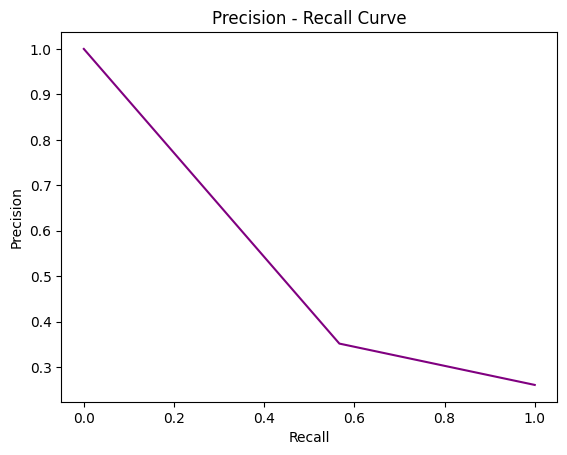

In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_proba)
fig, ax = plt.subplots()
ax.plot(recall, precision, color = 'purple')
ax.set_title('Precision - Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()

c:\Users\titob\Documents\Cursos\AnyoneAI\Final_Project\Credit_Score_MateoBongiorno\credit_risk_api\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


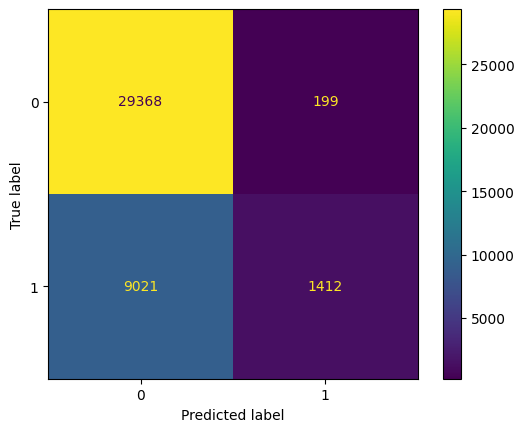

In [47]:
plot_confusion_matrix(xgb, X_train, y_train)

c:\Users\titob\Documents\Cursos\AnyoneAI\Final_Project\Credit_Score_MateoBongiorno\credit_risk_api\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


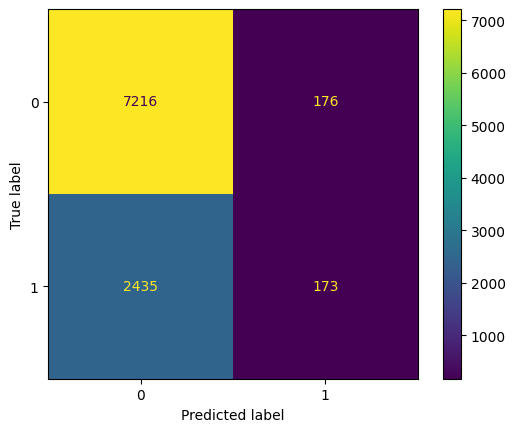

In [48]:
plot_confusion_matrix(xgb, X_test, y_test)

##### False Positive Rate and False Negative Rate against the Threshold

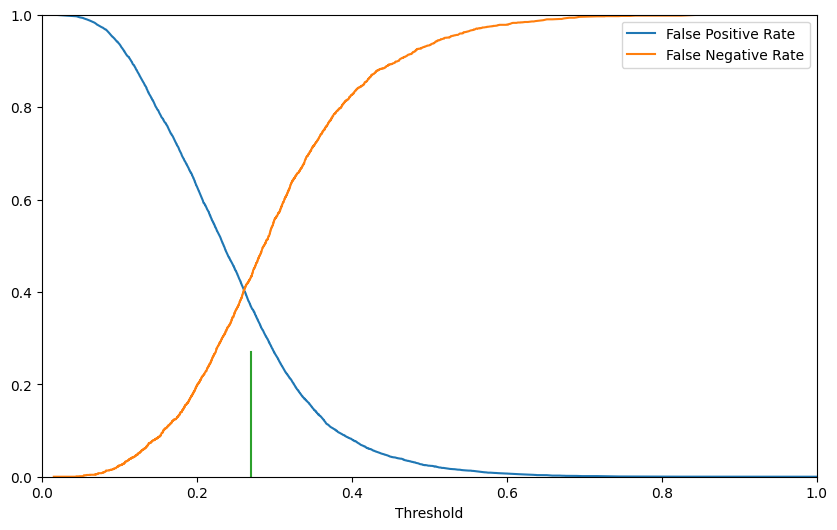

In [49]:
xgb_proba = xgb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, xgb_proba)

df_plot = pd.DataFrame({'Threshold' : thresholds, 'False Positive Rate' : fpr, 'False Negative Rate' : 1.-tpr})
ax = df_plot.plot(x = 'Threshold', y = ['False Positive Rate', 'False Negative Rate'], figsize = (10, 6))
ax.plot([0.27, 0.27], [0, 0.27]) 
ax.set_xbound(0, 1); ax.set_ybound(0, 1) 

#### XGBoost Classifier + RandomizedSearchCV

In [50]:
xgb_params = {
        'max_depth' : (3, 10),
        'learning_rate' : (0.1, 0.01),
        'n_estimators' : (100, 150),
        'gamma' : (0, 0.001),
        'eta' : (0.01, 0.1),
        'subsample' : (0.6, 0.8),
        'reg_alpha' : (0.005, 0.001,0)
}

In [51]:
xgb_rd = RandomizedSearchCV(
    XGBClassifier(random_state = 42), scoring = 'roc_auc', param_distributions = xgb_params,
     cv = 5, n_jobs = -1, n_iter = 5,verbose = 1
    )

xgb_rd.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                

In [52]:
xgb_pred_train = xgb_rd.predict(X_train)

xgb_pred_test = xgb_rd.predict(X_test)

In [53]:
xgb_rd_proba = xgb_rd.predict_proba(X_test)[:, 1]

xgb_rd_auc = roc_auc_score(y_test, xgb_rd_proba)
xgb_rd_auc

0.6338894342333281

In [54]:
print(classification_report(y_train, xgb_pred_train))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     29567
           1       0.97      0.22      0.35     10433

    accuracy                           0.79     40000
   macro avg       0.87      0.61      0.61     40000
weighted avg       0.83      0.79      0.74     40000



In [55]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85      7392
           1       0.47      0.06      0.11      2608

    accuracy                           0.74     10000
   macro avg       0.61      0.52      0.48     10000
weighted avg       0.67      0.74      0.65     10000



### Multilayer Perceptron (MLP)

In [56]:
mlp = keras.Sequential()
mlp.add(layers.Dense(480, input_dim = 1736, activation = 'relu'))
mlp.add(layers.Dense(125, activation = 'relu'))
mlp.add(layers.Dense(250, activation = 'relu'))
mlp.add(layers.Dense(80, activation = 'relu'))
mlp.add(layers.Dense(2, activation = 'softmax'))
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 480)               833760    
                                                                 
 dense_1 (Dense)             (None, 125)               60125     
                                                                 
 dense_2 (Dense)             (None, 250)               31500     
                                                                 
 dense_3 (Dense)             (None, 80)                20080     
                                                                 
 dense_4 (Dense)             (None, 2)                 162       
                                                                 
Total params: 945,627
Trainable params: 945,627
Non-trainable params: 0
_________________________________________________________________


In [57]:
mlp.compile(
        loss = 'sparse_categorical_crossentropy', 
        optimizer = 'adam',
        metrics = ['accuracy'],
)

In [58]:
early_stopping = keras.callbacks.EarlyStopping(
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True,
)

In [59]:
mlp.fit(
  X_train, 
  y_train, 
  epochs = 50, 
  batch_size = 32, 
  validation_split = 0.2,
  callbacks = [early_stopping]
)

c:\Users\titob\Documents\Cursos\AnyoneAI\Final_Project\Credit_Score_MateoBongiorno\credit_risk_api\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
1000/1000 [==============================] - 16s 14ms/step - loss: 0.5628 - accuracy: 0.7379 - val_loss: 0.5501 - val_accuracy: 0.7435
Epoch 2/50
1000/1000 [==============================] - 14s 14ms/step - loss: 0.5429 - accuracy: 0.7381 - val_loss: 0.5469 - val_accuracy: 0.7431
Epoch 3/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.5246 - accuracy: 0.7446 - val_loss: 0.5510 - val_accuracy: 0.7368
Epoch 4/50
1000/1000 [==============================] - 14s 14ms/step - loss: 0.4939 - accuracy: 0.7608 - val_loss: 0.5731 - val_accuracy: 0.7132
Epoch 5/50
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4512 - accuracy: 0.7836 - val_loss: 0.6325 - val_accuracy: 0.7147
Epoch 6/50
1000/1000 [==============================] - 14s 14ms/step - loss: 0.3971 - accuracy: 0.8122 - val_loss: 0.6869 - val_accuracy: 0.7072
Epoch 7/50
1000/1000 [==============================] - 14s 14ms/step - loss: 0.3438 - accuracy: 0.8411 - val_loss: 0.7955 -

In [60]:
mlp_pred_train = mlp.predict(X_train)

1250/1250 [==============================] - 5s 4ms/step


In [61]:
y_pred_bool = np.argmax(mlp_pred_train, axis = 1)

In [62]:
print(classification_report(y_train, y_pred_bool))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85     29567
           1       0.67      0.00      0.00     10433

    accuracy                           0.74     40000
   macro avg       0.70      0.50      0.43     40000
weighted avg       0.72      0.74      0.63     40000



In [63]:
mlp_pred_test = mlp.predict(X_test)

313/313 [==============================] - 1s 4ms/step


In [64]:
y_pred_bool_test = np.argmax(mlp_pred_test, axis = 1)

In [65]:
print(classification_report(y_test, y_pred_bool_test))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      7392
           1       0.50      0.00      0.00      2608

    accuracy                           0.74     10000
   macro avg       0.62      0.50      0.43     10000
weighted avg       0.68      0.74      0.63     10000

